In [1]:
import os
import sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

sys.path.insert(0, os.path.abspath('../'))

### Load in the ratings

In [2]:
ratings = pd.read_csv(
    '../data/ratings.csv',
    usecols=['userId', 'movieId', 'rating'])

ratings.shape

(100836, 3)

#### Filter the data to only have users that rated more than 100 movies

In [3]:
users_count = pd.DataFrame(
    ratings.groupby('userId').size(),
    columns=['count'])
active_users = list(set(users_count.query('count >= 100').index))
users_filter = ratings.userId.isin(active_users).values

#### Filter the data to only have movies that were rated more than 100 times

In [4]:
movies_count = pd.DataFrame(
    ratings.groupby('movieId').size(),
    columns=['count'])
popular_movies = list(set(movies_count.query('count >= 100').index))
movies_filter = ratings.movieId.isin(popular_movies).values

#### Combine the filters to filter the initial data

In [5]:
filtered_ratings = ratings[users_filter & movies_filter]

filtered_ratings.shape

(14096, 3)

We went from 100836 to 14096 ratings, and that is to avoid the data being sparce

#### Construct the rating matrix

In [6]:
ratings_matrix = filtered_ratings.pivot(
    index='userId', columns='movieId', values='rating'
).fillna(0)

print(ratings_matrix.shape)
ratings_matrix.head()

(248, 138)


movieId,1,2,6,10,32,34,39,47,50,110,...,7361,7438,8961,33794,44191,48516,58559,60069,68954,79132
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,4.0,3.0,4.0,4.0,0.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,...,0.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,5.0,0.0,0.0,4.5,0.0,4.0,0.0


In total we have 248 users left with 138 movies

### Creating the model and testing it

In [7]:
from src.modules.naive_neighbour_method import NaiveNeighbourMethod, calculate_mean_error

user_id = 1
neighbors = range(10, 130, 10)

In [8]:
def run_test(method='cosine'):
    predictor = NaiveNeighbourMethod(
        similarity_method=method,
        ratings_matrix=ratings_matrix
    )
    
    similarities = predictor.compute_similarities(user_id)
    losses = []
    
    for i in neighbors:
        user_vector = np.array(ratings_matrix.loc[user_id])
        predictions = predictor.predict(
            user_id,
            ratings_matrix.columns,
            similarities=similarities,
            num_neighbors=i
        )

        losses.append(
            calculate_mean_error(user_vector, predictions)
        )
        
    return losses

I have created a helper that will compute the similarities before hand to increase performace since it's going to be the same for all of our tests

#### Using the cosine similarity method

In [9]:
cosine_losses = run_test('cosine')

#### Using Mean-Squared Distance method

In [10]:
mean_squared_losses = run_test('mean_squared_distance')

#### Using Pearson Correlation Coefficient method

In [11]:
pearson_losses = run_test('pearson')

#### Using Spearman Rank Correlation Coefficient method

In [12]:
spearman_losses = run_test('spearman')

### Plotting the results

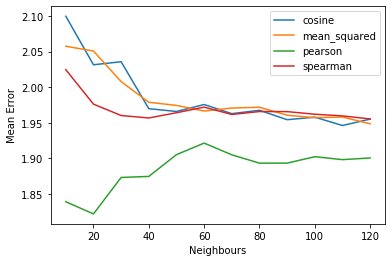

In [15]:
plt.plot(neighbors, cosine_losses, label='cosine')
plt.plot(neighbors, mean_squared_losses, label='mean_squared')
plt.plot(neighbors, pearson_losses, label='pearson')
plt.plot(neighbors, spearman_losses, label='spearman')

plt.xlabel('Neighbours')
plt.ylabel('Mean Error')

plt.legend()